In [ ]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import cv2
from skimage.morphology import disk

# Task 1
Implement the following Low Pass Filters

i. Ideal LPF

ii. Butterworth LPF

iii. Gaussian LPF


Before proceeding onward to create the mentioned filters, we need to implement a function that can perform Discrete Fourier Transformation (DFT) on images to transform the spatial representation of images to representation in the frequency domain. The DFT of a 2D image $f(x,y)$ of resolution $M \times N$ is,
	$$
	    F(u, v) = \sum_{x=0}^{M-1}\sum_{y=0}^{N-1}f(x,y)e^{-j2\pi(\frac{ux}{M} + \frac{vy}{N})}
	$$
where, $u = 0, 1, 2, \dots M-1$ and $v = 0, 1, 2, \dots N-1$. On the contrary, given the transform $F(u,v)$, we can obtain $f(x,y)$ by using \textit{inverse discrete Fourier transform} (IDFT),
	$$
	    f(x, y) = \frac{1}{MN}\sum_{u=0}^{M-1}\sum_{v=0}^{N-1}F(u, v)e^{-j2\pi(\frac{ux}{M} + \frac{vy}{N})}
	$$
where, $x = 0, 1, 2, \dots M-1$ and $y = 0, 1, 2, \dots N-1$. Here, $f$ is in the spatial domain and $F$ is in the frequency domain.

In [ ]:
def normalization(image, range=255):
    image_max = np.max(image)
    image_min = np.min(image)
    return ((image - image_min)/(image_max - image_min)) * range

In [ ]:
def DFT(image):
    frequency_response = np.fft.fft2(image)
    shifted_frequency_response = np.fft.fftshift(frequency_response)
    return shifted_frequency_response

In [ ]:
def inverse_DFT(image):
    return np.real(np.fft.ifft2(np.fft.ifftshift(image)))

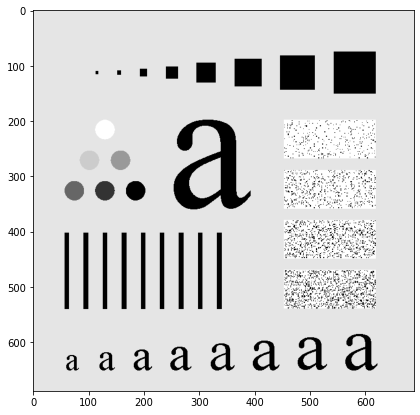

In [ ]:
test_pattern = Image.open('/content/drive/MyDrive/DIP3E_Original_Images_CH04/Fig0442(a)(characters_test_pattern).tif')
test_pattern = np.array(test_pattern)
fig = plt.figure(figsize=(10, 7))
plt.imshow(test_pattern, origin='upper', cmap='gray')

Let's try out this implementation on the test-pattern image shown above.

In [ ]:
test_pattern_DFT2 = np.abs(DFT(test_pattern))

In [ ]:
print(np.mean(test_pattern_DFT2))
print(np.max(test_pattern_DFT2))

21083.545240686584
98131169.0


In [ ]:
test_pattern_DFT = normalization(np.log(np.abs(DFT(test_pattern))))

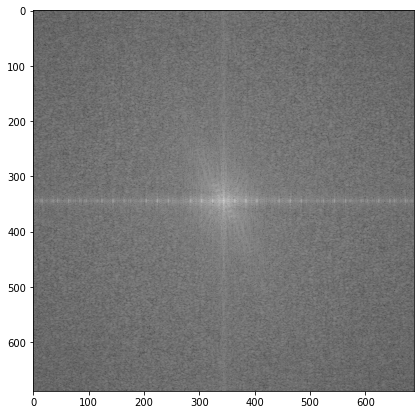

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.imshow(test_pattern_DFT, origin='upper', cmap='gray')

Note that we need to perform log transformation on the absolute value of the frequency response to make it clearly visible for display. The pixels at the center of the image signify small frequency values, whereas, the pixels at the periphery signify large frequency values.

In [ ]:
print(np.max(test_pattern_DFT))

1.0


In [ ]:
print(np.mean(test_pattern_DFT))

0.44548210631203217


Now, let's move on and start working on creating filters. A 2-D lowpass filter that passes without attenuation all frequencies within a circle of radius from the origin, and \textit{“cuts off”} all frequencies outside this, circle is called an \textit{ideal lowpass filter} (ILPF); it is specified by the transfer function,
    $$
        H(u, v) =\begin{cases}
        1, & \text{if $D(u,v) \leq D_0$}.\\
        0, & \text{if $D(u,v) > D_0$}.
  \end{cases}
    $$
where, $D_0$ is the cutoff frequency, $D(u,v)$ is the Euclidean distance between a point $(u,v)$ in the frequency domain and the center of the $M \times N$ matrix, that is,
$$D(u,v) = \sqrt{\left(u - \frac{M}{2}\right)^2 + \left(v - \frac{N}{2}\right)^2}$$

In [ ]:
def ideal_lowpass_filter(dim, cutoff):
    filter =np.zeros(dim)
    cx, cy =dim[0]//2, dim[1]//2
    for x in range(dim[0]):
        for y in range(dim[1]):
            d = np.sqrt((x - cx)**2 + (y - cy)**2)
            if d <= cutoff:
                filter[x, y] = 1
            else:
                filter[x, y] = 0
    return filter

Now, let's see try to produce an ideal lowpass filter with a cutoff frequency of 10.

In [ ]:
ILPF1 = ideal_lowpass_filter(np.shape(test_pattern), 10)

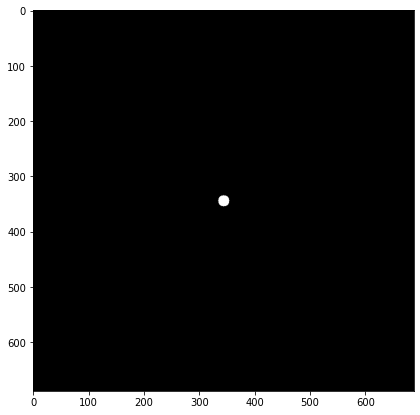

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.imshow(ILPF1, origin='upper', cmap='gray')

In [ ]:
def apply_ILPF(image, cutoff):
    filter = ideal_lowpass_filter(np.shape(image), cutoff)
    frequency_response = DFT(image)
    # resF = normalization(np.log(np.abs(frequency_response))) * filter
    resF = frequency_response * filter
    resS = inverse_DFT(resF)
    return resS

In [ ]:
test_pattern_ILPF = apply_ILPF(test_pattern, 60)

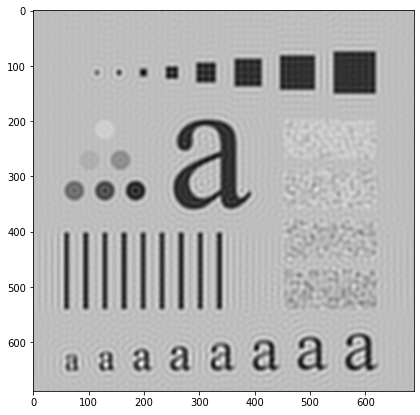

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.imshow(test_pattern_ILPF, origin='upper', cmap='gray')

Now, let's try out ILPFs with cutoff frequencies 10, 30, 60, 160 and 460 on the image shown before.

In [ ]:
cutoff_freqs = [10, 30, 60, 160, 460]

In [ ]:
i_low_pass_res = []
for cutoff in cutoff_freqs:
    i_low_pass_res.append(apply_ILPF(test_pattern, cutoff))

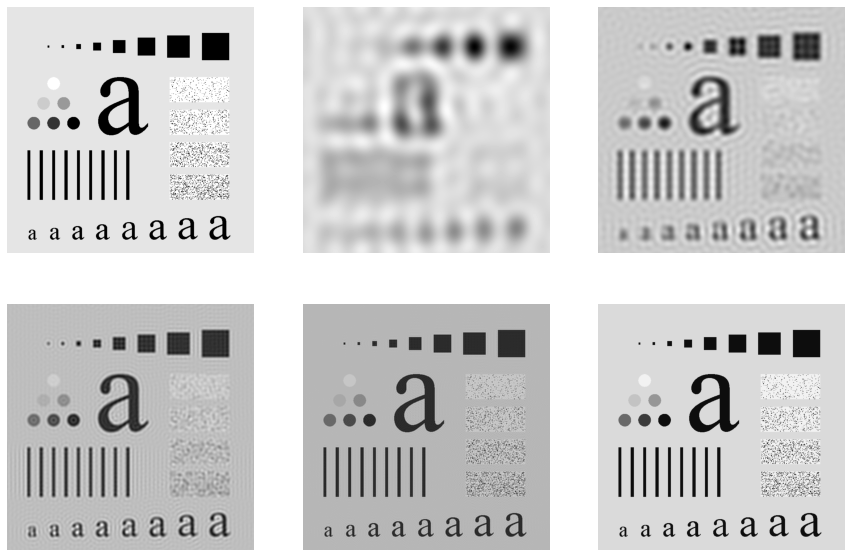

In [ ]:
fig = plt.figure(figsize=(15, 10))

fig.add_subplot(2, 3, 1)
plt.imshow(test_pattern, origin='upper', cmap='gray')
plt.axis('off')

for i in range(5):
    fig.add_subplot(2, 3, i + 2)
    plt.imshow(i_low_pass_res[i], origin='upper', cmap='gray')
    plt.axis('off')

Here, we can perceive with pristine clarity the ripple-effect or the ringing-effect that manifests in the convoluted images. An element-wise multiplication of the frequency response of the original image with the filter is the same as convolving the spatial representation of the original image with sinc function-like kernel (actually a Bessel function). This results in the ripple-effect seen in the images above. The power removed by these filters was 13.1, 7.2, 4.9, 2.4, and 0.6% of the total, respectively.

Now, let's try to create Butterworth lowpass filters. The transfer function of a Butterworth lowpass filter (BLPF) of order $n$, with cutoff frequency at a distance $D_0$ from the center of the frequency rectangle, is defined as,
$$H(u,v) = \frac{1}{1+ \left[\frac{D(u,v)}{D_0}\right]^{2n}}$$


In [ ]:
def butterworth_lowpass_filter(dim, cutoff, n=2):
    filter =np.zeros(dim)
    cx, cy =dim[0]//2, dim[1]//2
    for x in range(dim[0]):
        for y in range(dim[1]):
            d = np.sqrt((x - cx)**2 + (y - cy)**2)
            filter[x, y] = 1/(1 + (d/cutoff)**(2 * n))
    return filter

Here, the BLPF function can be controlled to approach the characteristics of the ILPF using higher values of n, and the GLPF for lower values of $n$, while providing a smooth transition in from low to high frequencies. Thus, we can use a BLPF to approach the sharpness of an ILPF function with considerably less ringing.

Now, let's see try to produce an Butterworth lowpass filter with a cutoff frequency of 20 and order 2.

In [ ]:
BLPF1 = butterworth_lowpass_filter(np.shape(test_pattern), 20)

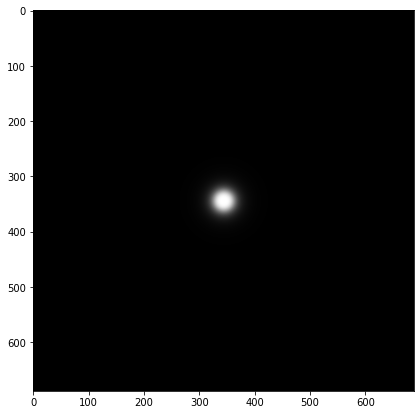

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.imshow(BLPF1, origin='upper', cmap='gray')

In [ ]:
def apply_BLPF(image, cutoff):
    filter = butterworth_lowpass_filter(np.shape(image), cutoff)
    frequency_response = DFT(image)
    # resF = normalization(np.log(np.abs(frequency_response))) * filter
    resF = frequency_response * filter
    resS = inverse_DFT(resF)
    return resS

In [ ]:
test_pattern_BLPF = apply_BLPF(test_pattern, 60)

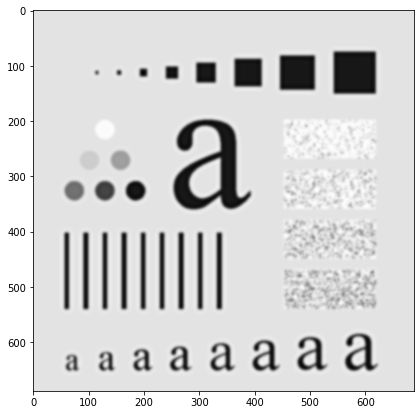

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.imshow(test_pattern_BLPF, origin='upper', cmap='gray')

Now, let's try out BLPFs with cutoff frequencies 10, 30, 60, 160 and 460 and order 2 on the image shown before.

In [ ]:
b_low_pass_res = []
for cutoff in cutoff_freqs:
    b_low_pass_res.append(apply_BLPF(test_pattern, cutoff))

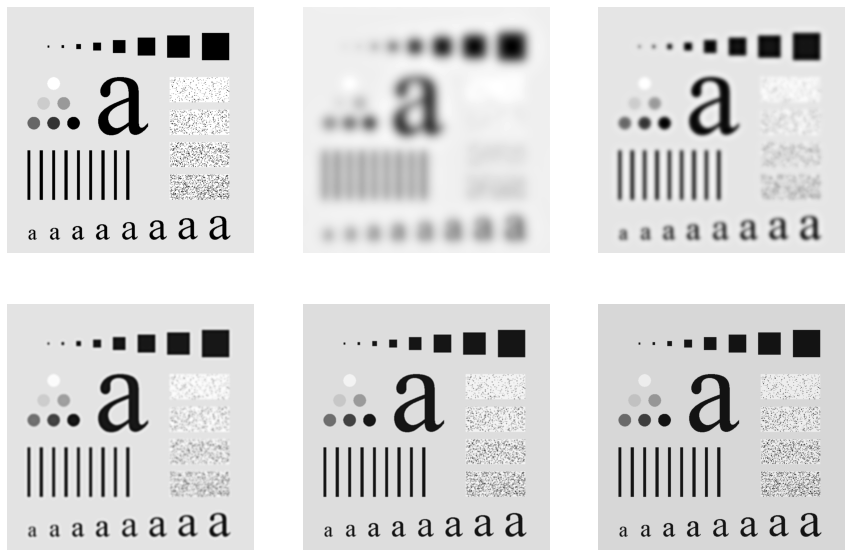

In [ ]:
fig = plt.figure(figsize=(15, 10))

fig.add_subplot(2, 3, 1)
plt.imshow(test_pattern, origin='upper', cmap='gray')
plt.axis('off')

for i in range(5):
    fig.add_subplot(2, 3, i + 2)
    plt.imshow(b_low_pass_res[i], origin='upper', cmap='gray')
    plt.axis('off')

As we can see from the results above, in terms of blurring, the images are between the results obtained with using ILPFs and GLPFs. The degree of blurring with the BLPF was less than with the ILPF, but more than with the GLPF. The spatial domain kernel obtainable from a BLPF of order 1 has no ringing. Generally, ringing is imperceptible in filters of order 2 or 3, but can become significant in filters of higher orders.

Now, let's move onto Gaussian lowpass filters. Gaussian lowpass filter (GLPF) transfer functions have the form,
$$H(u,v) = e^{\frac{-D^2(u,v)}{2\sigma^2}}$$
where, $D(u,v)$ is the Euclidean distance between a point $(u,v)$ in the frequency domain and the center of the $M \times N$ matrix, as aforementioned and $\sigma$ is the measure of spread about the center. So, we set $\sigma = D_0$, which is the cutoff frequency.

In [ ]:
def gaussian_lowpass_filter(dim, cutoff):
    filter =np.zeros(dim)
    cx, cy =dim[0]//2, dim[1]//2
    for x in range(dim[0]):
        for y in range(dim[1]):
            d = np.sqrt((x - cx)**2 + (y - cy)**2)
            filter[x, y] = np.exp(-(d**2)/(2 * (cutoff**2)))
    return filter

In [ ]:
def apply_GLPF(image, cutoff):
    filter = gaussian_lowpass_filter(np.shape(image), cutoff)
    frequency_response = DFT(image)
    # resF = normalization(np.log(np.abs(frequency_response))) * filter
    resF = frequency_response * filter
    resS = inverse_DFT(resF)
    return resS

Now, let's see try to produce an Gaussian lowpass filter with a cutoff frequency of 20.

In [ ]:
GLPF1 = gaussian_lowpass_filter(np.shape(test_pattern), 20)

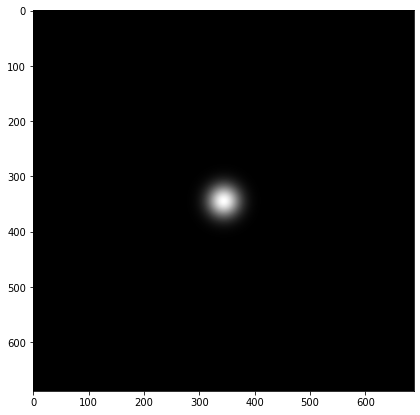

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.imshow(GLPF1, origin='upper', cmap='gray')

In [ ]:
test_pattern_GLPF = apply_GLPF(test_pattern, 60)

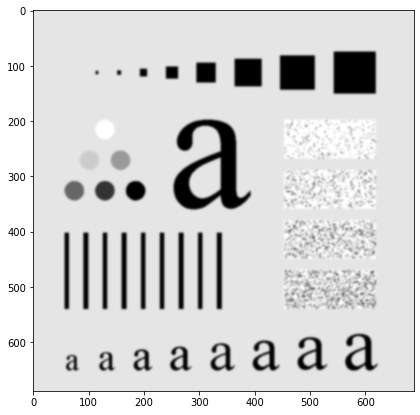

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.imshow(test_pattern_GLPF, origin='upper', cmap='gray')

We know that the inverse Fourier transform of a frequency domain Gaussian function is Gaussian also. This means that a spatial Gaussian filter kernel, obtained by computing the IDFT of Gaussian lowpass filter, will have no ringing. This implies that, if an image is convolved with such a filter, we won't see any rippling effect.

Now, let's try out GLPFs with cutoff frequencies 10, 30, 60, 160 and 460 on the image shown before, and see if it's true.

In [ ]:
g_low_pass_res = []
for cutoff in cutoff_freqs:
    g_low_pass_res.append(apply_GLPF(test_pattern, cutoff))

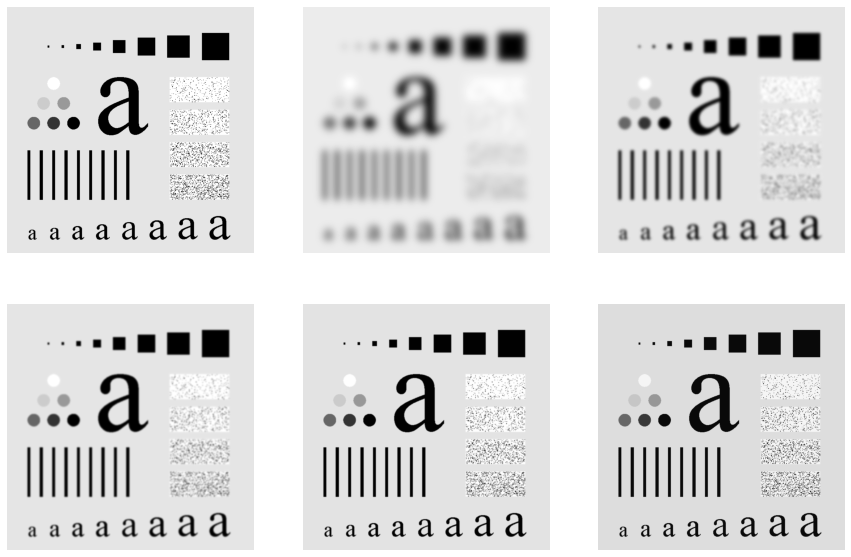

In [ ]:
fig = plt.figure(figsize=(15, 10))

fig.add_subplot(2, 3, 1)
plt.imshow(test_pattern, origin='upper', cmap='gray')
plt.axis('off')

for i in range(5):
    fig.add_subplot(2, 3, i + 2)
    plt.imshow(g_low_pass_res[i], origin='upper', cmap='gray')
    plt.axis('off')

The GLPF achieved slightly less smoothing than the ILPF. The key difference is that we are assured of no ringing when using a GLPF. This is an important consideration in practice, especially in situations in which any type of artifact is unacceptable, as in medical imaging.

# Task 2
Convert the Low Pass Filters above to High Pass Filters

i. Ideal HPF

ii. Butterworth HPF

iii. Gaussian HPF

Now that we have established the formulation of the 3 types of lowpass filters shown above, we can easily create their highpass counterparts. Let's start with Ideal highpass filters. An ideal highpass filter (IHPF) transfer function is given by,
$$
        H(u, v) =\begin{cases}
        0, & \text{if $D(u,v) \leq D_0$}.\\
        1, & \text{if $D(u,v) > D_0$}.
  \end{cases}$$

In [ ]:
def ideal_highpass_filter(dim, cutoff):
    filter =np.zeros(dim)
    cx, cy =dim[0]//2, dim[1]//2
    for x in range(dim[0]):
        for y in range(dim[1]):
            d = np.sqrt((x - cx)**2 + (y - cy)**2)
            if d <= cutoff:
                filter[x, y] = 0
            else:
                filter[x, y] = 1
    return filter

In [ ]:
def apply_IHPF(image, cutoff):
    filter = ideal_highpass_filter(np.shape(image), cutoff)
    frequency_response = DFT(image)
    # resF = normalization(np.log(np.abs(frequency_response))) * filter
    resF = frequency_response * filter
    resS = inverse_DFT(resF)
    return Image.fromarray(resS)

Now, let's see try to produce an ideal highpass filter with a cutoff frequency of 10.

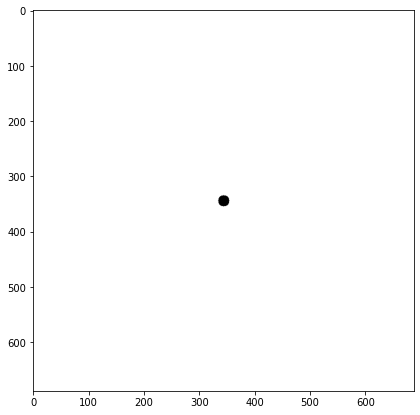

In [ ]:
IHPF1 = ideal_highpass_filter(np.shape(test_pattern), 10)
fig = plt.figure(figsize=(10, 7))
plt.imshow(IHPF1, origin='upper', cmap='gray')

In [ ]:
test_pattern_IHPF = apply_IHPF(test_pattern, 60)

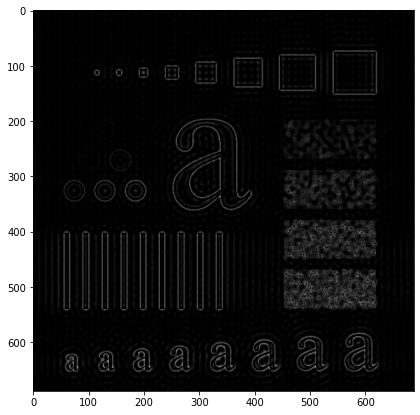

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.imshow(test_pattern_IHPF, origin='upper', cmap='gray')

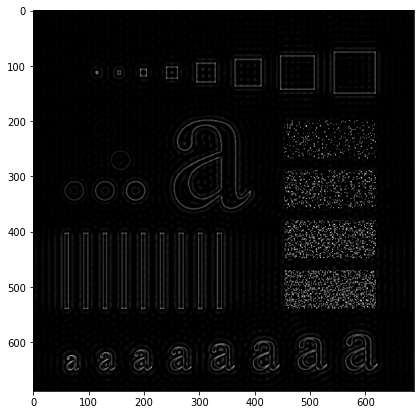

In [ ]:
res = test_pattern_ILPF - test_pattern
fig = plt.figure(figsize=(10, 7))
plt.imshow(Image.fromarray(res), origin='upper', cmap='gray')

Now, let's try out ILPFs with cutoff frequencies 10, 30, 60, 160 and 460 on the image shown before.

In [ ]:
i_high_pass_res = []
for cutoff in cutoff_freqs:
    i_high_pass_res.append(apply_IHPF(test_pattern, cutoff))

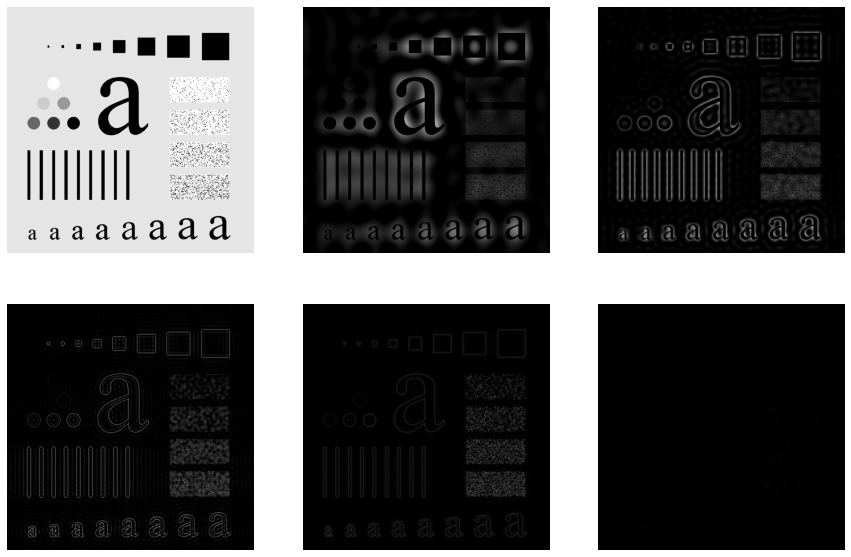

In [ ]:
fig = plt.figure(figsize=(15, 10))

fig.add_subplot(2, 3, 1)
plt.imshow(test_pattern, origin='upper', cmap='gray')
plt.axis('off')

for i in range(5):
    fig.add_subplot(2, 3, i + 2)
    plt.imshow(i_high_pass_res[i], origin='upper', cmap='gray')
    plt.axis('off')

Highpass filtering produces images with negative values. The resultant images shown above are not scaled, so the negative values are clipped by the display at 0 (black). The key objective of highpass filtering is to sharpen. Also, because the highpass filters used here set the DC term to zero, the images have essentially no tonality. For IHPFs, we can notice the rippling effect and distortions.

Now, let's try to create the Butterworth highpass filter. The transfer function of a Butterworth highpass filter (BHPF) of order $n$, with cutoff frequency at a distance $D_0$ from the center of the frequency rectangle, is defined as,$$H(u,v) = \frac{1}{1+ \left[\frac{D_0}{D(u,v)}\right]^{2n}}$$

In [ ]:
def butterworth_highpass_filter(dim, cutoff, n=2):
    filter =np.zeros(dim)
    cx, cy =dim[0]//2, dim[1]//2
    for x in range(dim[0]):
        for y in range(dim[1]):
            d = np.sqrt((x - cx)**2 + (y - cy)**2)
            filter[x, y] = 1/(1 + (cutoff/d)**(2 * n))
    return filter

In [ ]:
def apply_BHPF(image, cutoff):
    filter = butterworth_highpass_filter(np.shape(image), cutoff)
    frequency_response = DFT(image)
    # resF = normalization(np.log(np.abs(frequency_response))) * filter
    resF = frequency_response * filter
    resS = inverse_DFT(resF)
    return Image.fromarray(resS)

Here, the BHPF function can be controlled to approach the characteristics of the IHPF using higher values of n, and the GHPF for lower values of n, while providing a smooth transition in from low to high frequencies. Thus, we can use a BHPF to approach the sharpness of an IHPF function with considerably less ringing.

Now, let’s see try to produce an Butterworth highpass filter with a cutoff frequency of 60 and order 2.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


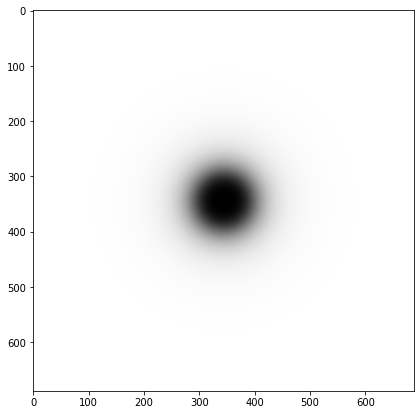

In [ ]:
BHPF1 = butterworth_highpass_filter(np.shape(test_pattern), 60)
fig = plt.figure(figsize=(10, 7))
plt.imshow(BHPF1, origin='upper', cmap='gray')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


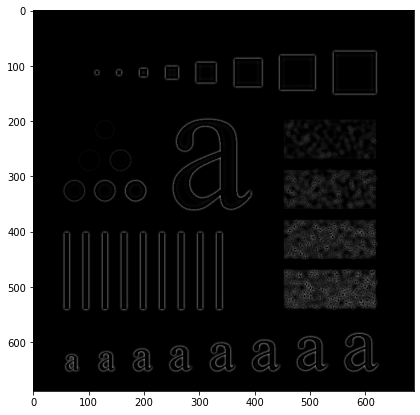

In [ ]:
test_pattern_BHPF = apply_BHPF(test_pattern, 60)
fig = plt.figure(figsize=(10, 7))
plt.imshow(test_pattern_BHPF, origin='upper', cmap='gray')

Now, let's try BHPFs with cutoff frequencies 10, 30, 60, 160 and 460 and order 2 on the image shown before.

In [ ]:
b_high_pass_res = []
for cutoff in cutoff_freqs:
    b_high_pass_res.append(apply_BHPF(test_pattern, cutoff))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


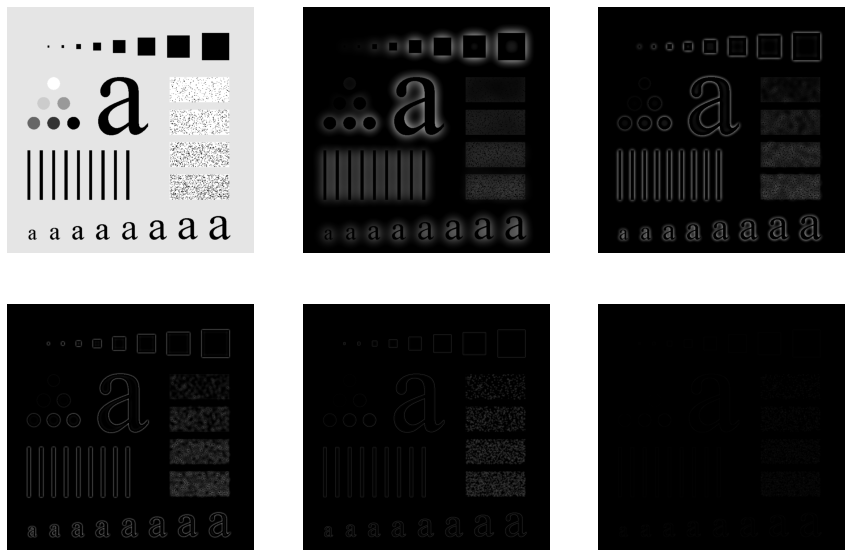

In [ ]:
fig = plt.figure(figsize=(15, 10))

fig.add_subplot(2, 3, 1)
plt.imshow(test_pattern, origin='upper', cmap='gray')
plt.axis('off')

for i in range(5):
    fig.add_subplot(2, 3, i + 2)
    plt.imshow(b_high_pass_res[i], origin='upper', cmap='gray')
    plt.axis('off')

As mentioned earlier, these highpass filtered images are negative at some of the pixels and are clipped at 0 for displaying purposes. The resultant images for BHPFs show very negligible rippling effect for higher orders. The higher the order of a BHPF, the more it emulates an IHPF, and contrarily, the lesser the order, the more it emulates a GHPF. As the highpass filters used here set the DC term to zero, the images have essentially no tonality.

Now, let's work with Gaussian highpass filters. Gaussian highpass filter (GHPF) transfer functions have the form,
$$H(u,v) = 1 - e^{\frac{-D^2(u,v)}{2\sigma^2}}$$
where, $D(u,v)$ is the Euclidean distance between a point $(u,v)$ in the frequency domain and the center of the $M \times N$ matrix, as aforementioned and $\sigma$ is the measure of spread about the center. So, we set $\sigma = D_0$, which is the cutoff frequency.

In [ ]:
def gaussian_highpass_filter(dim, cutoff):
    filter =np.zeros(dim)
    cx, cy =dim[0]//2, dim[1]//2
    for x in range(dim[0]):
        for y in range(dim[1]):
            d = np.sqrt((x - cx)**2 + (y - cy)**2)
            filter[x, y] = 1 - (np.exp(-(d**2)/(2 * (cutoff**2))))
    return filter

In [ ]:
def apply_GHPF(image, cutoff):
    filter = gaussian_highpass_filter(np.shape(image), cutoff)
    frequency_response = DFT(image)
    # resF = normalization(np.log(np.abs(frequency_response))) * filter
    resF = frequency_response * filter
    resS = inverse_DFT(resF)
    return Image.fromarray(resS)

Now, let’s see try to produce an Gaussian highpass filter with a cutoff frequency of 60.

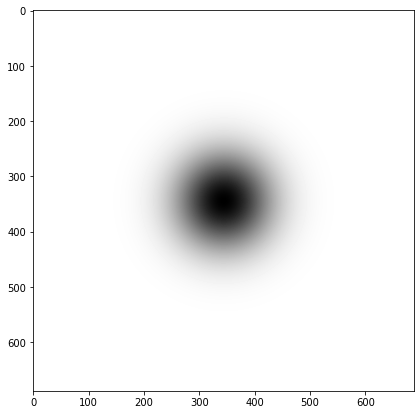

In [ ]:
GHPF1 = gaussian_highpass_filter(np.shape(test_pattern), 60)
fig = plt.figure(figsize=(10, 7))
plt.imshow(GHPF1, origin='upper', cmap='gray')

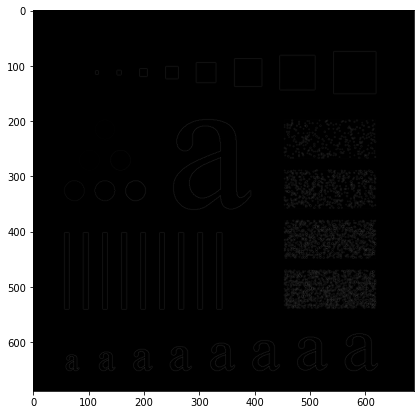

In [ ]:
test_pattern_GHPF = apply_GHPF(test_pattern, 230)
fig = plt.figure(figsize=(10, 7))
plt.imshow(test_pattern_GHPF, origin='upper', cmap='gray')

Now, let's try GHPFs with cutoff frequencies 10, 30, 60, 160 and 460 on the image shown before.

In [ ]:
g_high_pass_res = []
for cutoff in cutoff_freqs:
    g_high_pass_res.append(apply_GHPF(test_pattern, cutoff))

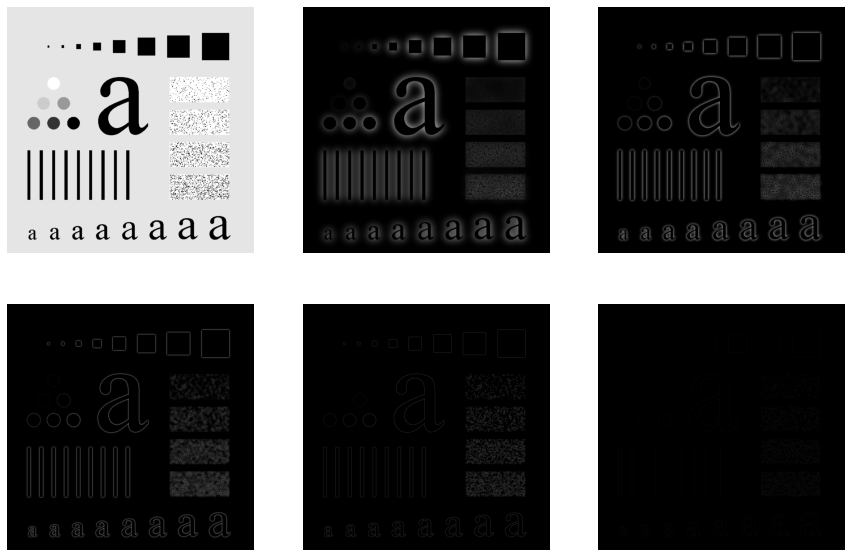

In [ ]:
fig = plt.figure(figsize=(15, 10))

fig.add_subplot(2, 3, 1)
plt.imshow(test_pattern, origin='upper', cmap='gray')
plt.axis('off')

for i in range(5):
    fig.add_subplot(2, 3, i + 2)
    plt.imshow(g_high_pass_res[i], origin='upper', cmap='gray')
    plt.axis('off')

As mentioned earlier, these highpass filtered images are negative at some of the pixels and are clipped at 0 for displaying purposes. The resultant images for GHPFs show no rippling effect to the invariant characteristic of Gaussian distributions when DFT or IDFT is performed on them. As the highpass filters used here set the DC term to zero, the images have essentially no tonality.

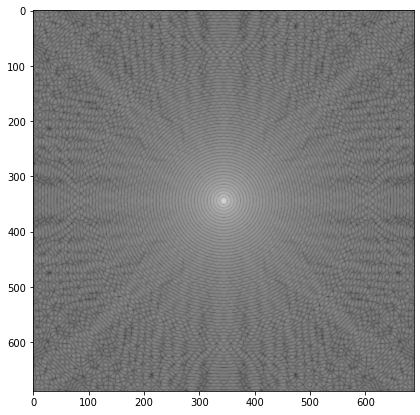

In [ ]:
IHPF1iDFT = inverse_DFT(IHPF1)
fig = plt.figure(figsize=(10, 7))
plt.imshow(np.log(np.abs(np.fft.fftshift(IHPF1iDFT))), origin='upper', cmap='gray')


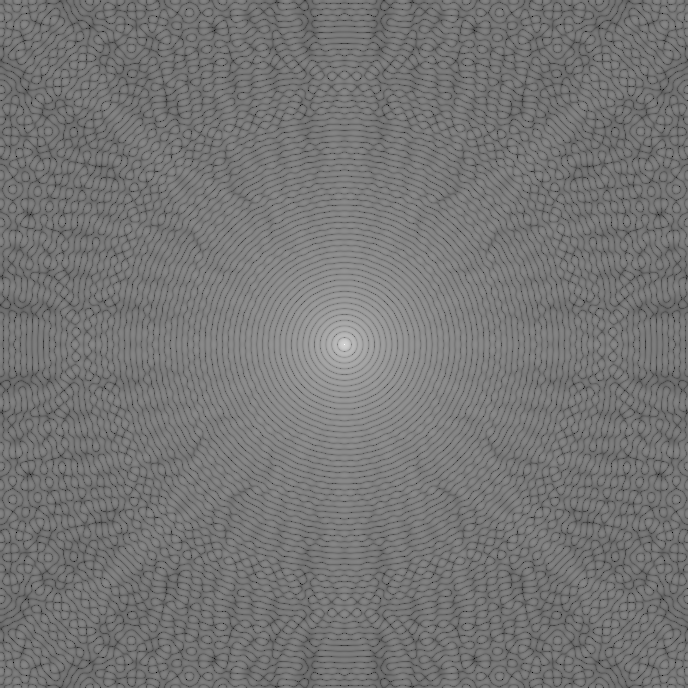

In [ ]:
fig = px.imshow(np.log(np.abs(np.fft.fftshift(IHPF1iDFT))), binary_string=True)
fig.show()

As an additional exercise, let's create the spatial representations of an ILPF and an IHPF and see the ringing-effect manifest on the resultant kernels. This is done simply by performing \textit{inverse discrete Fourier transform} (IDFT) on the filter images.
Formally,$$h_{LP}(x,y) = \Im^{-1}[H_{LP(u,v)}]$$

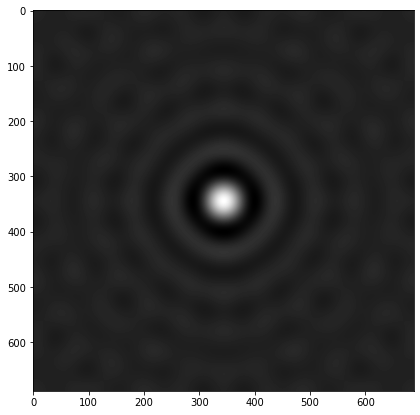

In [ ]:
ILPF1iDFT = inverse_DFT(ILPF1)
fig = plt.figure(figsize=(10, 7))
plt.imshow(np.log1p(np.fft.fftshift(ILPF1iDFT)), origin='upper', cmap='gray')

We can create the highpass variant of this simply by,
$$h_{HP}(x,y) = \Im^{-1}[H_{HP(u,v)}] = \Im^{-1}[1 - H_{LP(u,v)}] = \delta(x, y) - h_{LP}(x, y)$$
where, $\delta$ is the unit impulse.


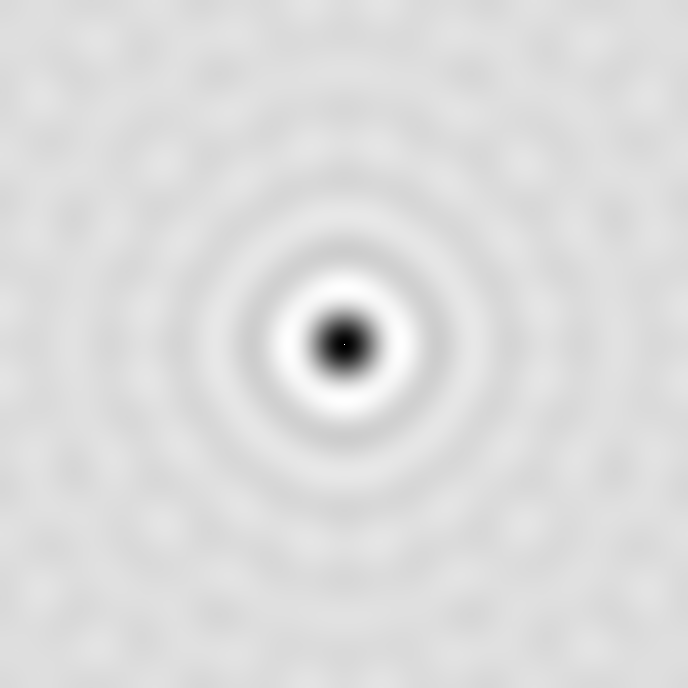

In [ ]:
IHPF1iDFT2 = 255 - normalization(np.log1p(np.fft.fftshift(ILPF1iDFT)))
IHPF1iDFT2[IHPF1iDFT2.shape[0]//2, IHPF1iDFT2.shape[1]//2] = 255
fig = px.imshow(IHPF1iDFT2, binary_string=True)
fig.show()

Here, we can notice a white dot in the center of the image. This is due to the unit impulse. We can notice the ringing effect for both lowpass and highpass variants of the ideal filters. And so, we can see the rippling effect in the equivalently convolved images as seen before.